# Volts Volatility-Based Predictive Trading Strategy

This notebook implements the complete Volts strategy pipeline:

1. **Data Acquisition** - Download historical price data
2. **Volatility Estimation** - Calculate historical volatility using multiple estimators
3. **Volatility Clustering** - Group assets by volatility characteristics
4. **Granger Causality Testing** - Identify predictive relationships
5. **Signal Generation** - Generate trading signals based on trends
6. **Backtesting** - Evaluate strategy performance

Run each cell sequentially to execute the complete strategy.

## Setup and Configuration

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import yaml
import warnings
from pathlib import Path
from datetime import datetime

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Execution started at: 2026-01-23 20:18:38


In [2]:
# Import strategy modules
from volatility_estimators import VolatilityEstimator, calculate_volatility_for_assets
from volatility_clustering import VolatilityClustering, cluster_assets_by_volatility
from granger_causality import GrangerCausalityAnalyzer, identify_trading_pairs
from signal_generator import SignalGenerator, SignalAnalyzer
from backtester import VoltBacktester

print("Strategy modules imported successfully!")

Strategy modules imported successfully!


In [3]:
# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"Assets: {config['data']['assets']}")
print(f"Data period: {config['data']['start_date']} to {config['data']['end_date']}")
print(f"Volatility estimator: {config['volatility']['primary_estimator']}")
print(f"Rolling window: {config['volatility']['rolling_window']} days")
print(f"Target cluster: Mid-volatility")
print(f"Optimal lag: {config['granger']['optimal_lag']} days")

Configuration loaded:
Assets: ['MSFT', 'GOOGL', 'NVDA', 'AMZN', 'META', 'QCOM', 'IBM', 'INTC', 'MU']
Data period: 2020-01-01 to 2025-12-31
Volatility estimator: yang_zhang
Rolling window: 20 days
Target cluster: Mid-volatility
Optimal lag: 5 days


## Step 1: Data Acquisition

Download historical OHLC price data for all assets in our universe.

In [4]:
print("="*80)
print("STEP 1: DATA ACQUISITION")
print("="*80)

tickers = config['data']['assets']
start_date = config['data']['start_date']
end_date = config['data']['end_date']

print(f"\nDownloading data for {len(tickers)} tickers...")
print(f"Period: {start_date} to {end_date}\n")

data_dict = {}
for ticker in tickers:
    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if len(df) > 0:
            # Fix MultiIndex columns issue (yfinance returns columns like ('Close', 'MSFT'))
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)
            
            data_dict[ticker] = df
            print(f"  {ticker}: {len(df)} days")
        else:
            print(f"  {ticker}: No data available")
    except Exception as e:
        print(f"  {ticker}: Error - {e}")

print(f"\nSuccessfully downloaded data for {len(data_dict)} assets")

STEP 1: DATA ACQUISITION

Period: 2020-01-01 to 2025-12-31

YF.download() has changed argument auto_adjust default to True
  MSFT: 1507 days
  GOOGL: 1507 days
  NVDA: 1507 days
  AMZN: 1507 days
  META: 1507 days
  QCOM: 1507 days
  IBM: 1507 days
  INTC: 1507 days
  MU: 1507 days

Successfully downloaded data for 9 assets


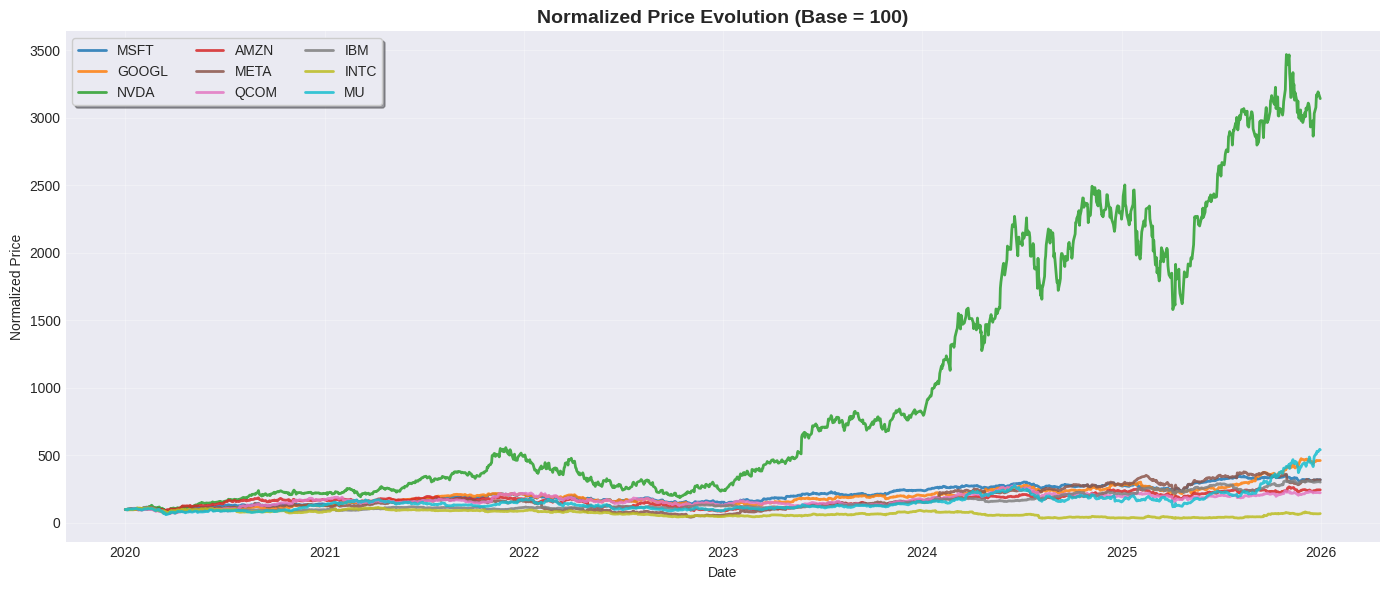


Data date range: 2020-01-02 00:00:00 to 2025-12-30 00:00:00


In [5]:
# Quick visualization of price data
fig, ax = plt.subplots(figsize=(14, 6))

# Use a distinct color palette with enough colors
colors = plt.cm.tab10(np.linspace(0, 1, len(data_dict)))

for idx, (ticker, df) in enumerate(data_dict.items()):
    # Normalize to 100 for comparison
    normalized = (df['Close'] / df['Close'].iloc[0]) * 100
    ax.plot(normalized.index, normalized.values, label=ticker, 
            color=colors[idx], alpha=0.85, linewidth=2)

ax.set_title('Normalized Price Evolution (Base = 100)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price')
ax.legend(loc='best', ncol=3, frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nData date range: {list(data_dict.values())[0].index[0]} to {list(data_dict.values())[0].index[-1]}")

## Step 2: Historical Volatility Estimation

Calculate historical volatility using the Yang-Zhang estimator (robust to opening jumps and drift).

In [6]:
print("="*80)
print("STEP 2: VOLATILITY ESTIMATION")
print("="*80)

vol_config = config['volatility']
print(f"\nUsing {vol_config['primary_estimator']} estimator")
print(f"Rolling window: {vol_config['rolling_window']} days")
print(f"Annualization factor: {vol_config['annualization_factor']}\n")

# Calculate volatility for all assets
volatility_df = calculate_volatility_for_assets(
    data_dict,
    estimator=vol_config['primary_estimator'],
    rolling_window=vol_config['rolling_window'],
    annualization_factor=vol_config['annualization_factor']
)

# Remove NaN values
volatility_df = volatility_df.dropna()

print(f"Volatility calculated for period: {volatility_df.index[0]} to {volatility_df.index[-1]}")
print(f"Data points: {len(volatility_df)}")
print("\nMean volatility by asset:")
mean_vols = volatility_df.mean().sort_values(ascending=False)
for ticker, vol in mean_vols.items():
    print(f"  {ticker}: {vol:.2%}")

STEP 2: VOLATILITY ESTIMATION

Using yang_zhang estimator
Rolling window: 20 days
Annualization factor: 252

Volatility calculated for period: 2020-01-31 00:00:00 to 2025-12-30 00:00:00
Data points: 1487

Mean volatility by asset:
  NVDA: 50.78%
  MU: 48.71%
  INTC: 43.84%
  META: 42.20%
  QCOM: 38.92%
  AMZN: 35.63%
  GOOGL: 32.49%
  MSFT: 27.82%
  IBM: 25.71%


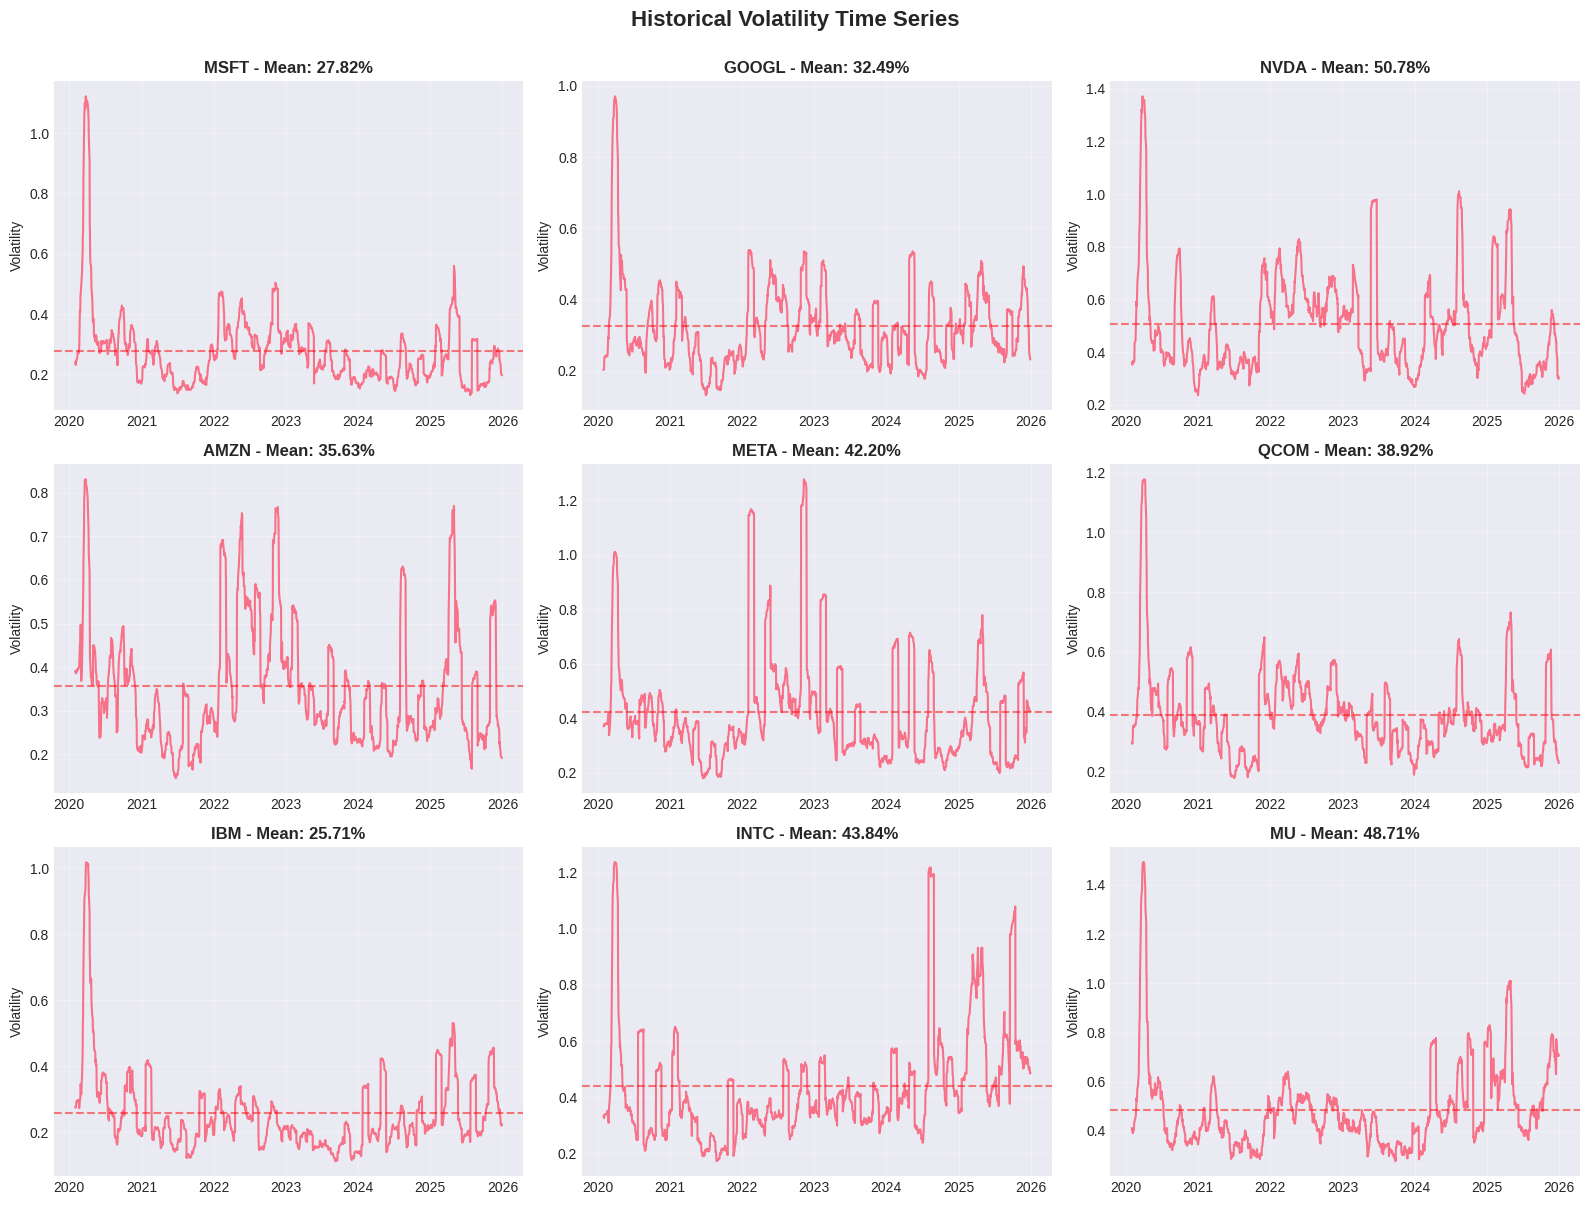

In [7]:
# Visualize volatility time series
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, (ticker, vol_series) in enumerate(volatility_df.items()):
    if idx < len(axes):
        axes[idx].plot(vol_series.index, vol_series.values, linewidth=1.5)
        axes[idx].set_title(f'{ticker} - Mean: {vol_series.mean():.2%}', fontweight='bold')
        axes[idx].set_ylabel('Volatility')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].axhline(y=vol_series.mean(), color='red', linestyle='--', alpha=0.5)

plt.suptitle('Historical Volatility Time Series', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Step 3: Volatility Clustering

Use K-means++ to cluster assets into low, mid, and high volatility groups.

We focus on the **mid-volatility cluster** as it represents the optimal balance between risk and profit potential.

In [8]:
print("="*80)
print("STEP 3: VOLATILITY CLUSTERING")
print("="*80)

cluster_config = config['clustering']
print(f"\nNumber of clusters: {cluster_config['n_clusters']}")
print(f"Target cluster: Mid-volatility (cluster {cluster_config['target_cluster']})\n")

# Perform clustering
clustering, mid_cluster_members = cluster_assets_by_volatility(
    volatility_df,
    n_clusters=cluster_config['n_clusters'],
    random_state=cluster_config['random_state'],
    target_cluster='mid'
)

STEP 3: VOLATILITY CLUSTERING

Number of clusters: 3
Target cluster: Mid-volatility (cluster 1)


Cluster Statistics:
 cluster_id  n_members  mean_volatility  median_volatility  std_volatility  min_volatility  max_volatility                members cluster_type
          0          3         0.286756           0.278236        0.034666        0.257144        0.324888       MSFT, GOOGL, IBM          Low
          2          4         0.401448           0.405577        0.036425        0.356253        0.438382 AMZN, META, QCOM, INTC          Mid
          1          2         0.497453           0.497453        0.014692        0.487064        0.507841               NVDA, MU         High

Mid-volatility cluster members: ['AMZN', 'META', 'QCOM', 'INTC']


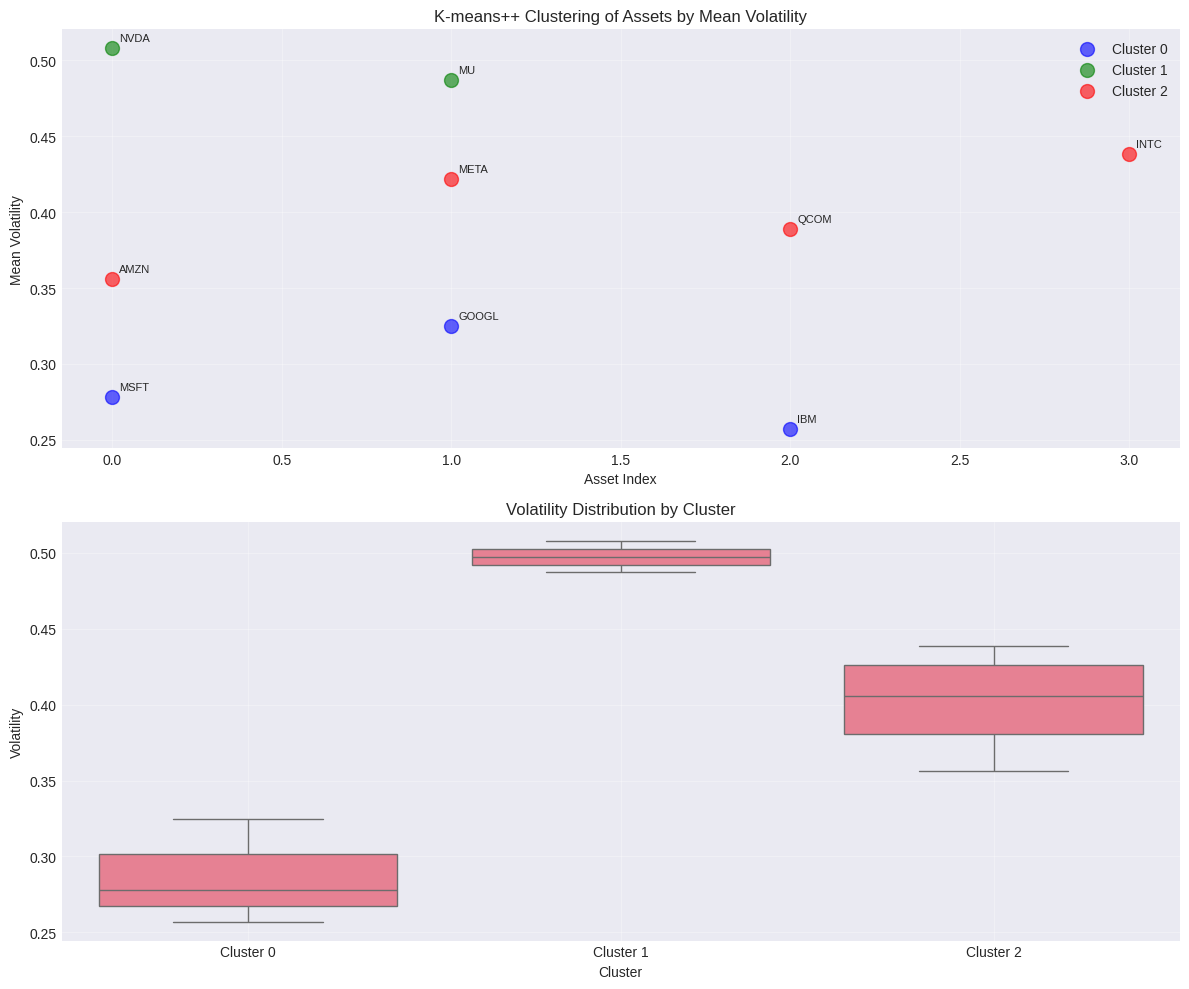

In [9]:
# Visualize clustering results
clustering.plot_clusters(volatility_df)

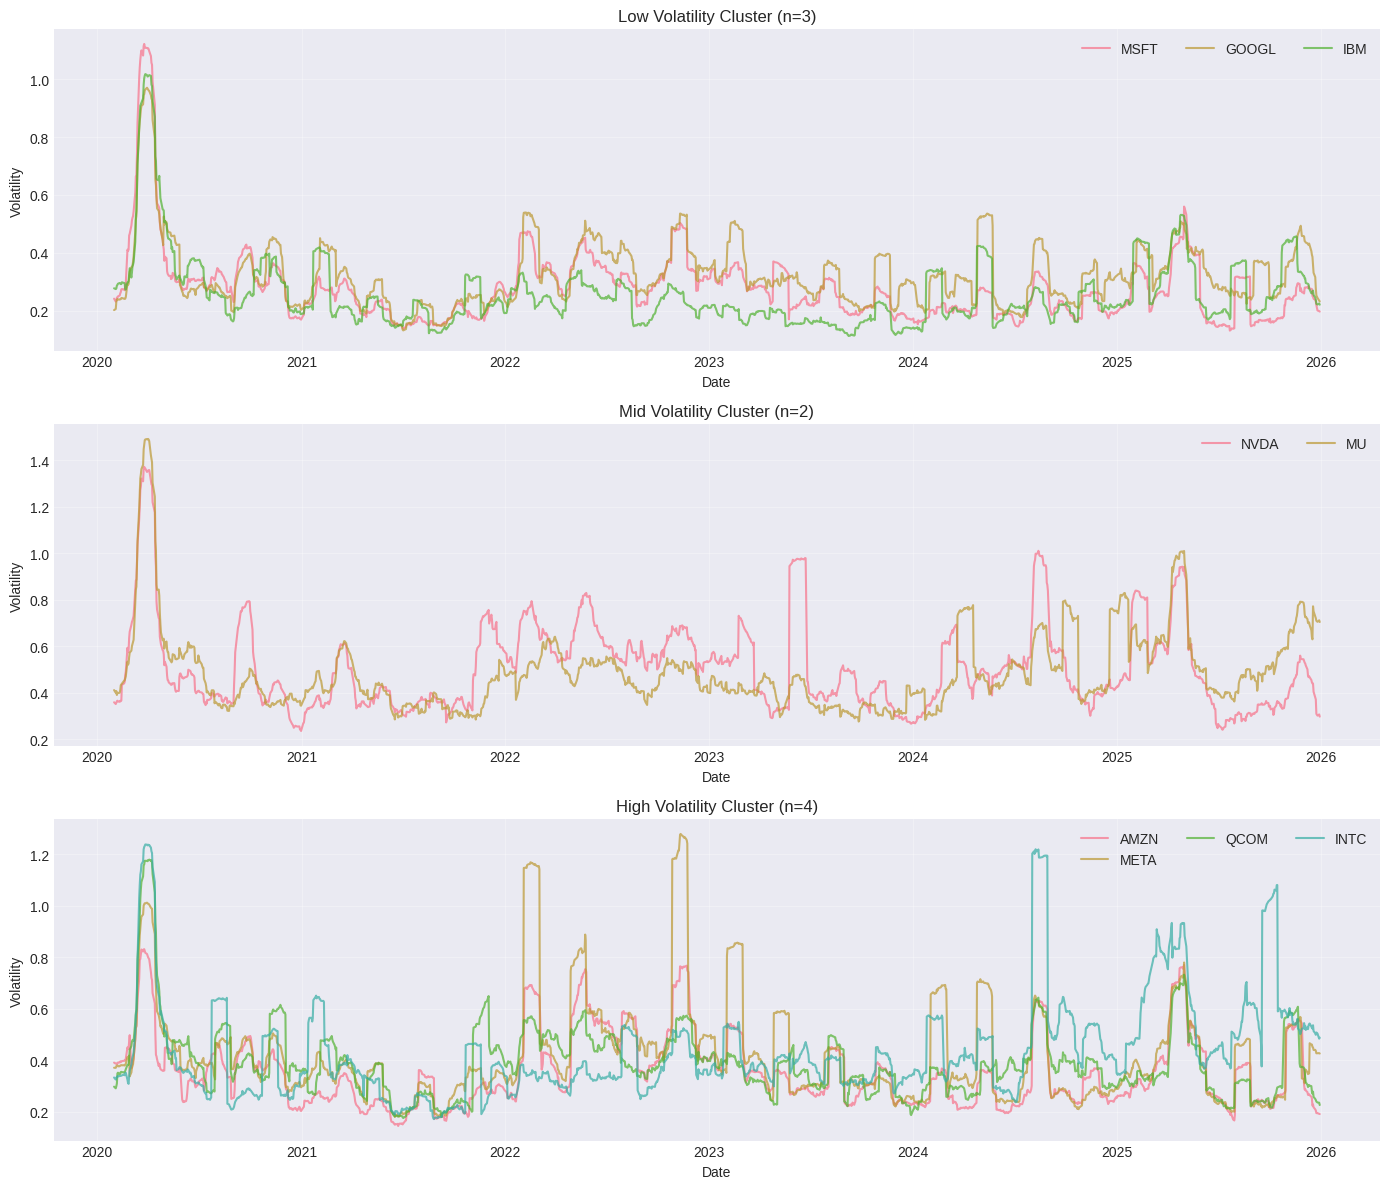

In [10]:
# Visualize time series by cluster
clustering.plot_time_series_by_cluster(volatility_df)

## Step 4: Granger Causality Analysis

Test for predictive relationships between volatility time series in the mid-cluster.

If Stock A's volatility **Granger-causes** Stock B's volatility (A → B), then past values of A's volatility help predict B's volatility beyond B's own past values.

In [11]:
print("="*80)
print("STEP 4: GRANGER CAUSALITY ANALYSIS")
print("="*80)

granger_config = config['granger']
print(f"\nTesting lags: {granger_config['min_lag']} to {granger_config['max_lag']}")
print(f"Optimal lag: {granger_config['optimal_lag']}")
print(f"Significance level: {granger_config['alpha']}")
print(f"\nTesting {len(mid_cluster_members)} assets in mid-cluster...\n")

# Identify trading pairs
trading_pairs, analyzer = identify_trading_pairs(
    volatility_df,
    mid_cluster_members,
    target_lag=granger_config['optimal_lag'],
    significance_level=granger_config['alpha'],
    max_lag=granger_config['max_lag'],
    remove_circular=True
)

if len(trading_pairs) == 0:
    print("\nWARNING: No significant Granger causality relationships found!")
    print("Consider:")
    print("  - Adjusting the significance level")
    print("  - Testing different lag ranges")
    print("  - Using a longer historical period")
else:
    print(f"\nFound {len(trading_pairs)} trading pairs!")

STEP 4: GRANGER CAUSALITY ANALYSIS

Testing lags: 2 to 30
Optimal lag: 5
Significance level: 0.05

Testing 4 assets in mid-cluster...

Testing Granger causality for 4 assets...
Testing pair 10/12...

Found 12 significant causality relationships
Filtered to 4 relationships with lag 5 ± 2
Removed circular relationships: 4 -> 3

Identified Trading Pairs:
predictor target  optimal_lag      p_value  f_statistic  n_significant_lags
     META   QCOM            6 7.034331e-16    14.284865                  30
     INTC   AMZN            6 2.221736e-10     9.600826                  29
     INTC   META            6 2.667594e-06     6.078342                  19

Found 3 trading pairs!


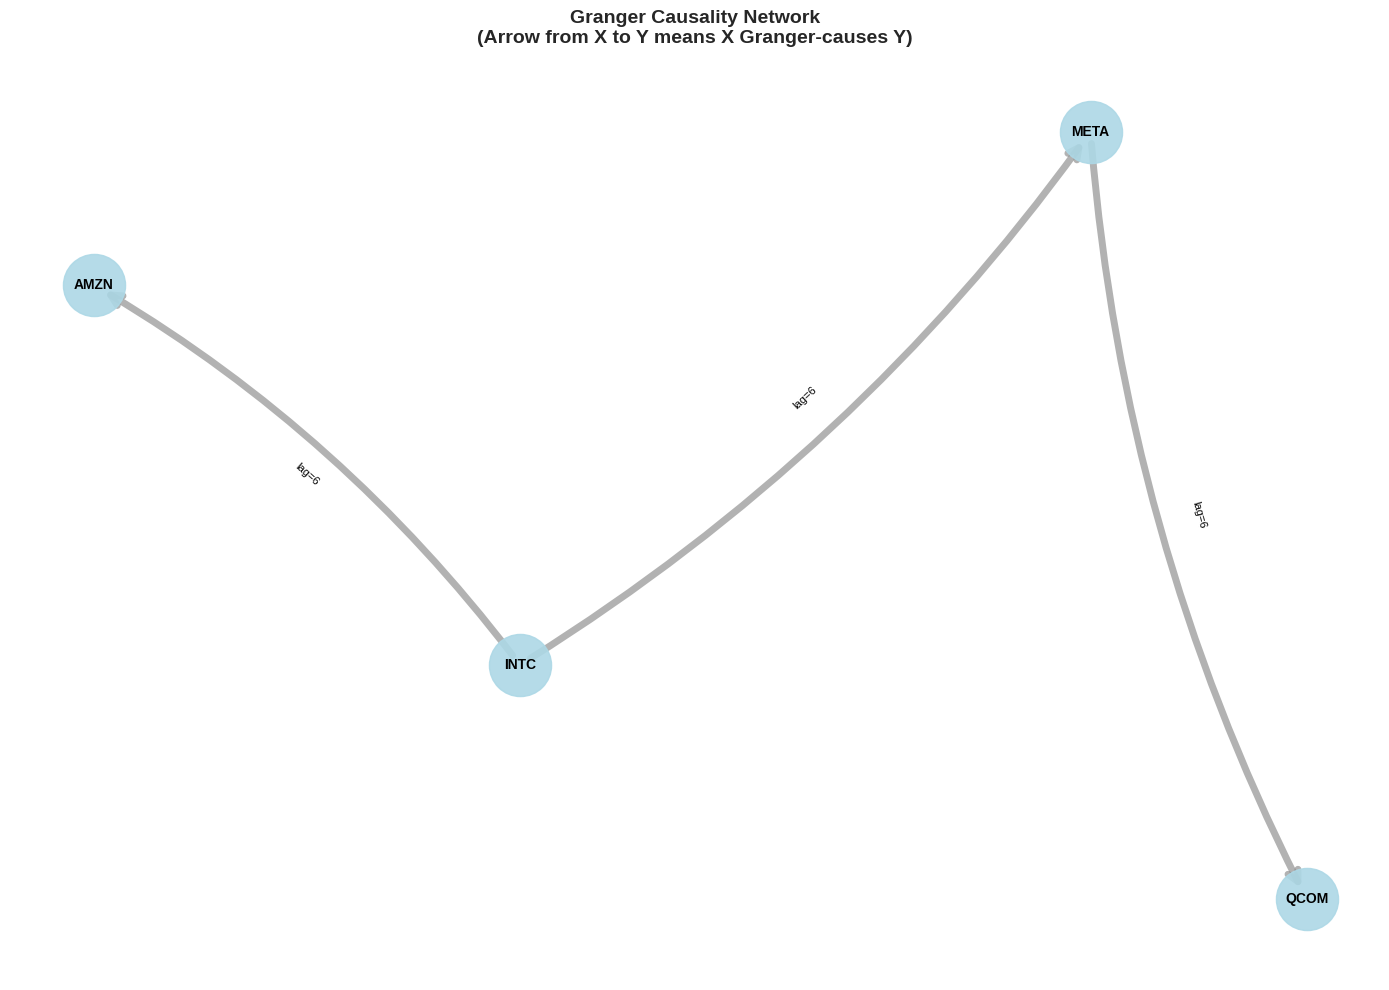

In [12]:
# Visualize causality network
if len(trading_pairs) > 0:
    analyzer.plot_causality_network(trading_pairs, figsize=(14, 10))
else:
    print("No trading pairs to visualize.")

In [13]:
# Display trading pairs details
if len(trading_pairs) > 0:
    print("\nTrading Pairs Details:")
    print("="*80)
    display(trading_pairs)
    
    print("\nInterpretation:")
    for _, row in trading_pairs.iterrows():
        print(f"\n{row['predictor']} -> {row['target']}:")
        print(f"  When {row['predictor']}'s volatility trends UP, BUY {row['target']}")
        print(f"  When {row['predictor']}'s volatility trends DOWN, SELL {row['target']}")
        print(f"  Optimal lag: {row['optimal_lag']} days")
        print(f"  P-value: {row['p_value']:.4f}")


Trading Pairs Details:


,predictor,target,optimal_lag,p_value,f_statistic,n_significant_lags
0,META,QCOM,6,7.034331e-16,14.284865,30
1,INTC,AMZN,6,2.221736e-10,9.600826,29
2,INTC,META,6,2.667594e-06,6.078342,19



Interpretation:

META -> QCOM:
  When META's volatility trends UP, BUY QCOM
  When META's volatility trends DOWN, SELL QCOM
  Optimal lag: 6 days
  P-value: 0.0000

INTC -> AMZN:
  When INTC's volatility trends UP, BUY AMZN
  When INTC's volatility trends DOWN, SELL AMZN
  Optimal lag: 6 days
  P-value: 0.0000

INTC -> META:
  When INTC's volatility trends UP, BUY META
  When INTC's volatility trends DOWN, SELL META
  Optimal lag: 6 days
  P-value: 0.0000


## Step 5: Signal Generation

Generate trading signals using trend-following on the predictor stock's volatility.

In [14]:
if len(trading_pairs) == 0:
    print("Cannot generate signals without trading pairs.")
else:
    print("="*80)
    print("STEP 5: SIGNAL GENERATION")
    print("="*80)
    
    strategy_config = config['strategy']
    print(f"\nStrategy type: {strategy_config['type']}")
    print(f"Trend method: {strategy_config['trend_method']}")
    print(f"Trend parameters: {strategy_config['trend_params']}\n")
    
    # Initialize signal generator
    signal_gen = SignalGenerator(
        trend_method=strategy_config['trend_method'],
        trend_params=strategy_config['trend_params']
    )
    
    # Generate signals for all pairs
    signals = signal_gen.generate_signals_for_all_pairs(volatility_df, trading_pairs)
    
    # Analyze signals
    stats = SignalAnalyzer.get_signal_statistics(signals)
    print("Signal Statistics:")
    display(stats)

STEP 5: SIGNAL GENERATION

Strategy type: trend_following
Trend method: sma_crossover
Trend parameters: {'fast_period': 5, 'slow_period': 20}

Signal Statistics:


,pair,n_buy,n_sell,n_hold,total_days,n_trades,pct_active
0,META->QCOM,724,744,19,1487,75,98.72226
1,INTC->AMZN,744,724,19,1487,81,98.72226
2,INTC->META,744,724,19,1487,81,98.72226



Plotting signals for META->QCOM...


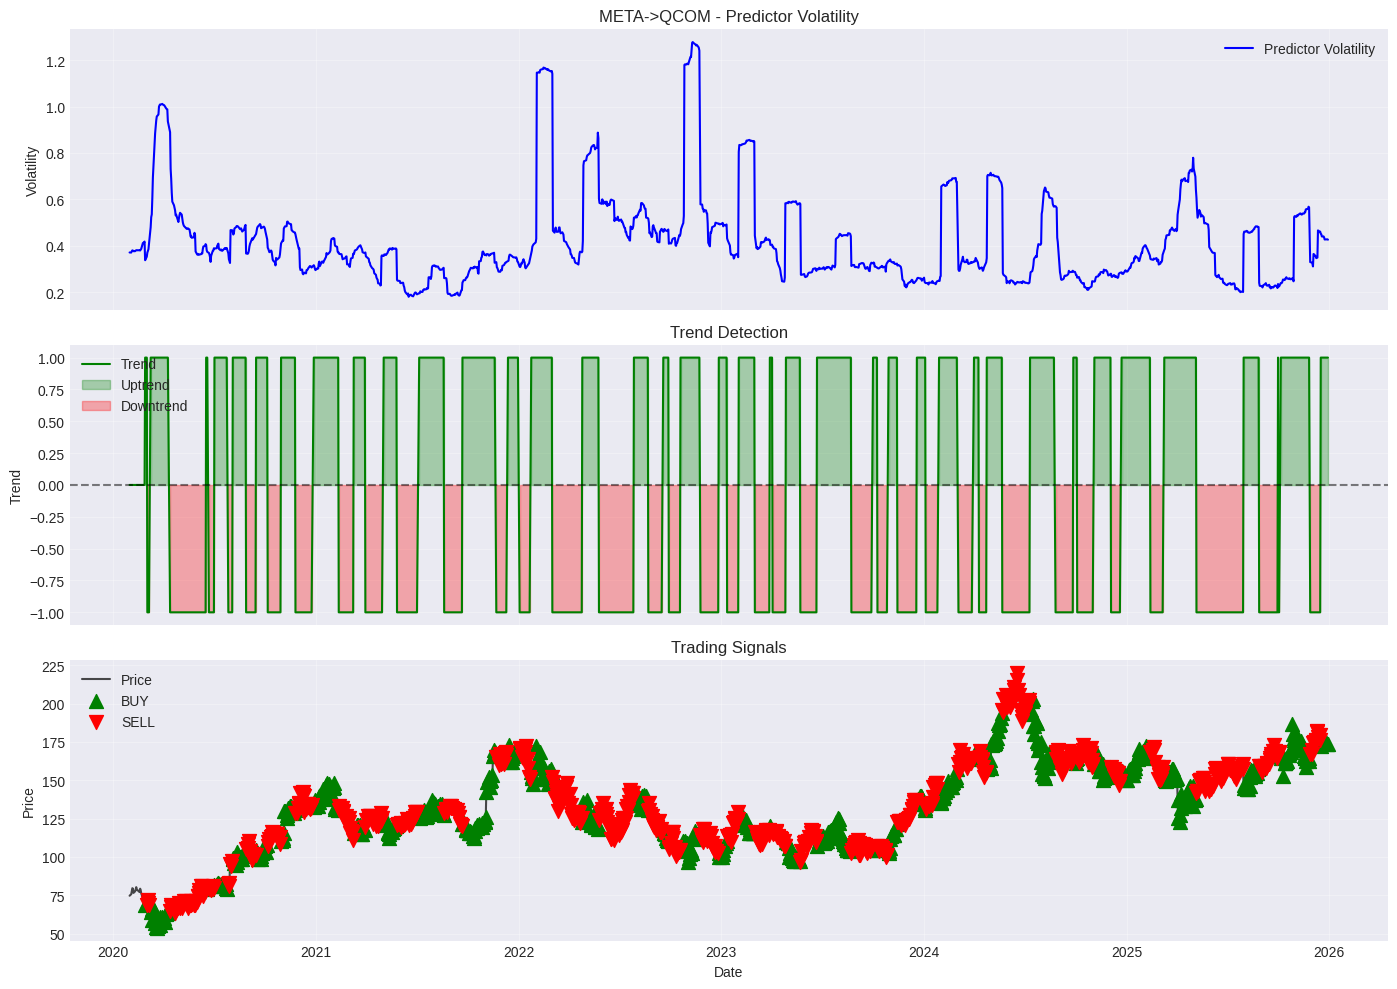


Plotting signals for INTC->AMZN...


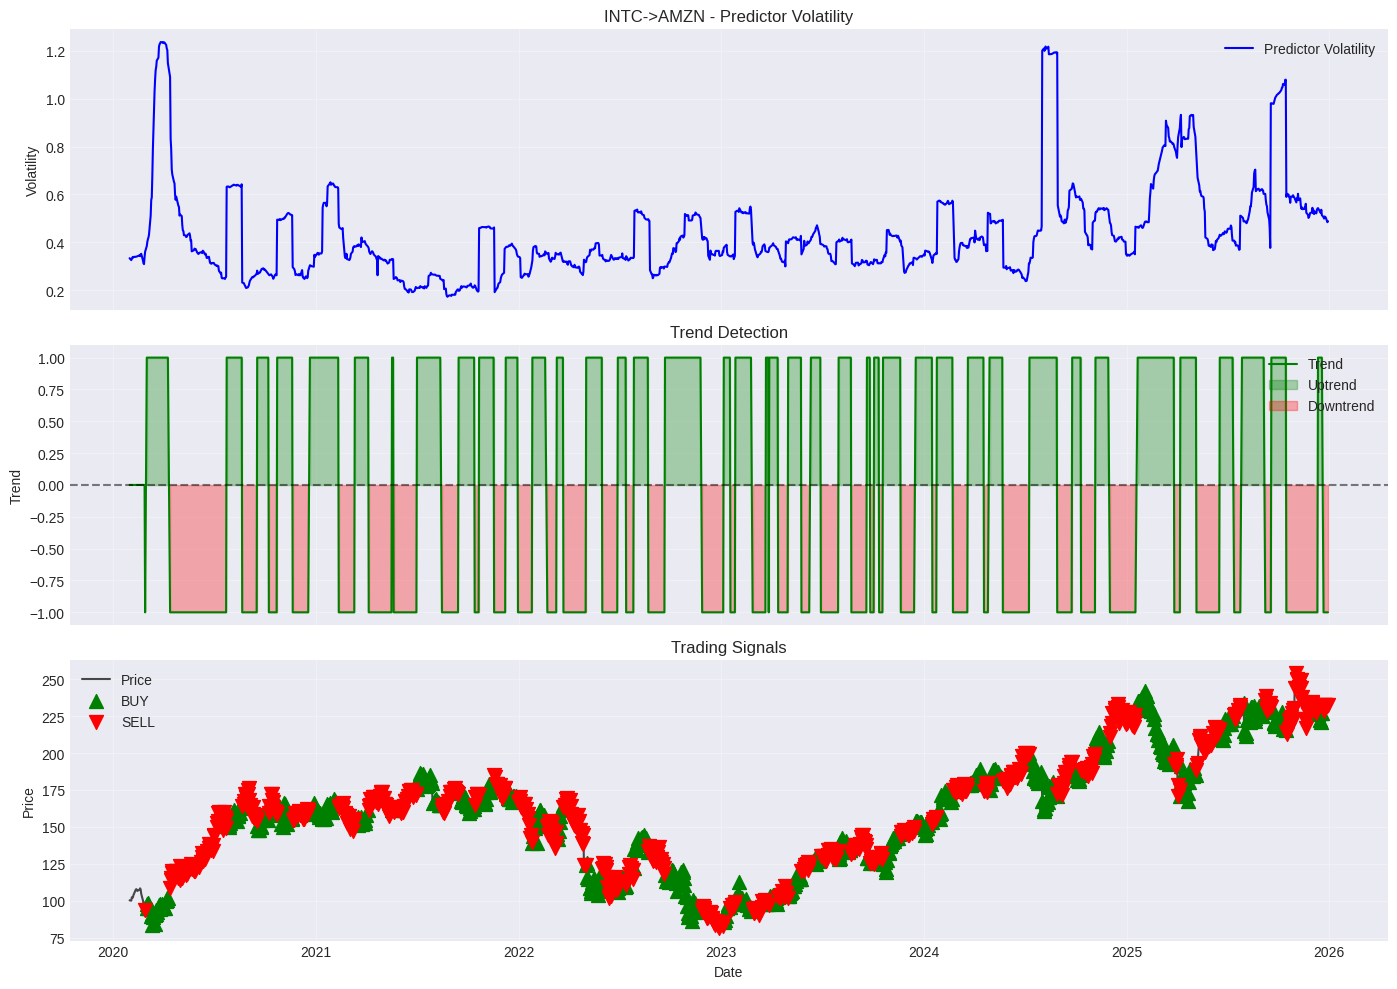


Plotting signals for INTC->META...


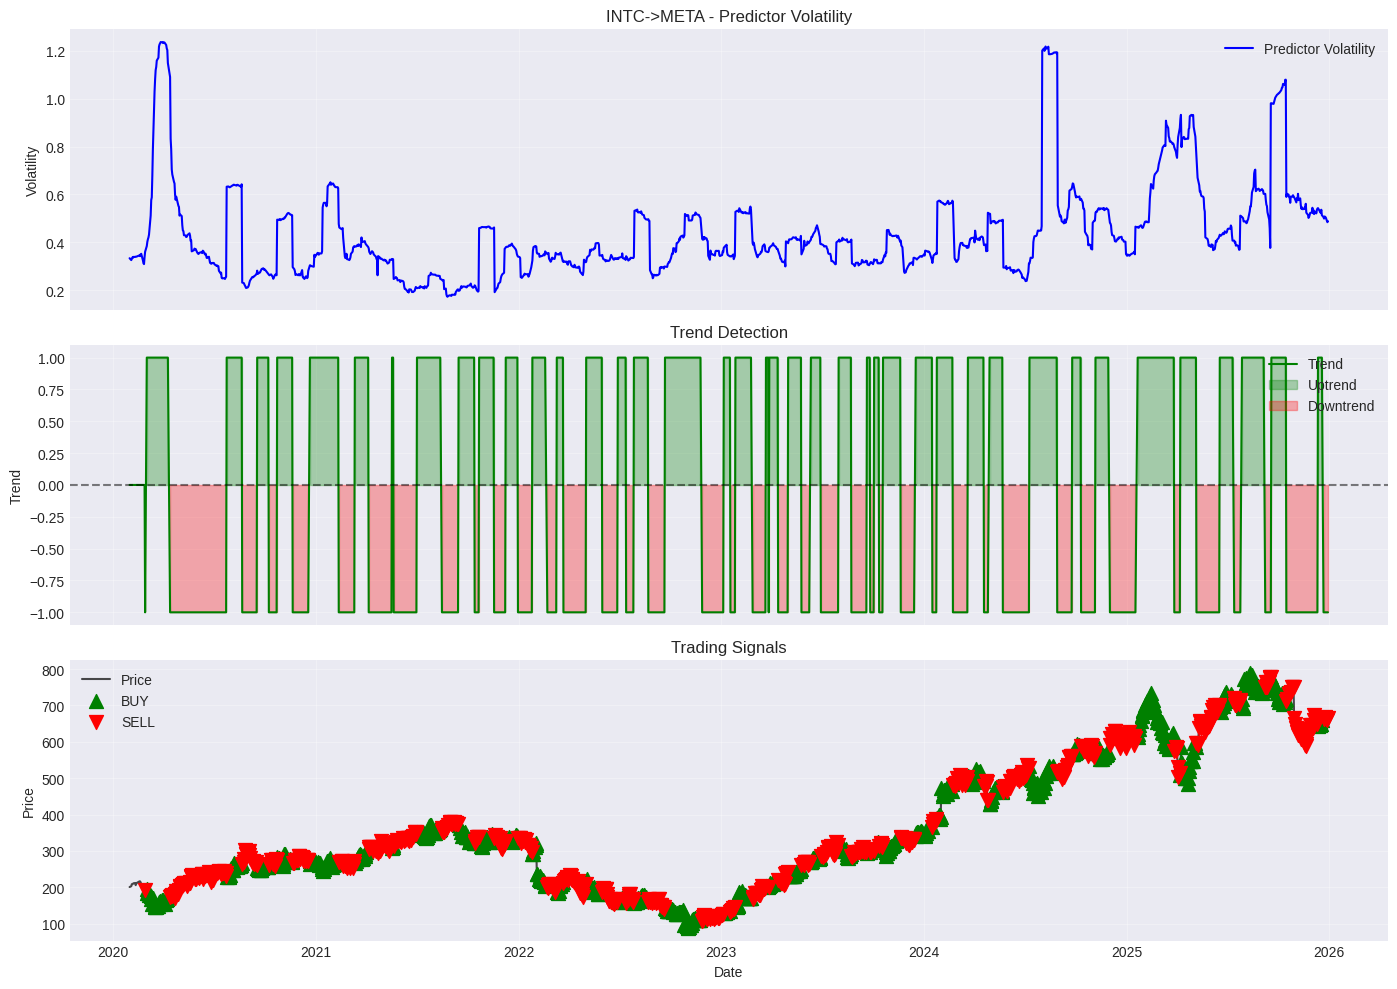

In [15]:
# Visualize signals for each pair
if len(trading_pairs) > 0:
    for pair_name, signals_df in signals.items():
        print(f"\nPlotting signals for {pair_name}...")
        
        target_ticker = pair_name.split('->')[1]
        target_price = data_dict[target_ticker]['Close']
        
        SignalAnalyzer.plot_signals(
            signals_df,
            price_data=target_price,
            title=pair_name
        )
        plt.show()

## Step 6: Backtesting

Evaluate strategy performance with realistic transaction costs and position sizing.

In [16]:
if len(trading_pairs) == 0:
    print("Cannot run backtest without trading pairs.")
else:
    print("="*80)
    print("STEP 6: BACKTESTING")
    print("="*80)
    
    backtest_config = config['backtest']
    strategy_config = config['strategy']
    
    print(f"\nBacktest period: {backtest_config['start_date']} to {backtest_config['end_date']}")
    print(f"Initial capital per pair: ${strategy_config['initial_capital']}")
    print(f"Total capital: ${strategy_config['initial_capital'] * len(trading_pairs)}")
    print(f"Commission: ${strategy_config['commission']} per trade")
    print(f"Slippage: {strategy_config['slippage']:.2%}\n")
    
    # Initialize backtester
    backtester = VoltBacktester(
        initial_capital_per_pair=strategy_config['initial_capital'],
        commission=strategy_config['commission'],
        slippage=strategy_config['slippage'],
        position_size_pct=strategy_config['position_size_pct']
    )
    
    # Run backtest
    results = backtester.run_backtest(
        data_dict,
        signals,
        start_date=pd.Timestamp(backtest_config['start_date']),
        end_date=pd.Timestamp(backtest_config['end_date'])
    )
    
    print("\nBacktest completed!")

STEP 6: BACKTESTING

Backtest period: 2020-01-01 to 2025-12-31
Initial capital per pair: $1000
Total capital: $3000
Commission: $9.0 per trade
Slippage: 0.05%


Backtest completed!


## Results Analysis

In [17]:
# Print detailed results
if len(trading_pairs) > 0:
    backtester.print_results()


VOLTS STRATEGY BACKTEST RESULTS

AGGREGATED PERFORMANCE:
Total Return: $-5805.94 (-193.53%)
Final Value: $-2805.94
Number of Trades: 4
Win Rate: 25.00%
Profit Factor: 0.43
Max Drawdown: 198.84%
Sharpe Ratio: 0.15
Sortino Ratio: 0.02
Calmar Ratio: nan

--------------------------------------------------------------------------------
PER-PAIR PERFORMANCE:
--------------------------------------------------------------------------------

META->QCOM:
  Return: $-1845.27 (-184.53%)
  Trades: 2 | Wins: 1 | Losses: 1 | Win Rate: 50.0%
  Max DD: 198.66% | Sharpe: -0.45 | Sortino: -0.03

INTC->AMZN:
  Return: $-1981.93 (-198.19%)
  Trades: 1 | Wins: 0 | Losses: 1 | Win Rate: 0.0%
  Max DD: 198.19% | Sharpe: -0.40 | Sortino: 0.00

INTC->META:
  Return: $-1978.75 (-197.87%)
  Trades: 1 | Wins: 0 | Losses: 1 | Win Rate: 0.0%
  Max DD: 197.87% | Sharpe: -0.40 | Sortino: 0.00


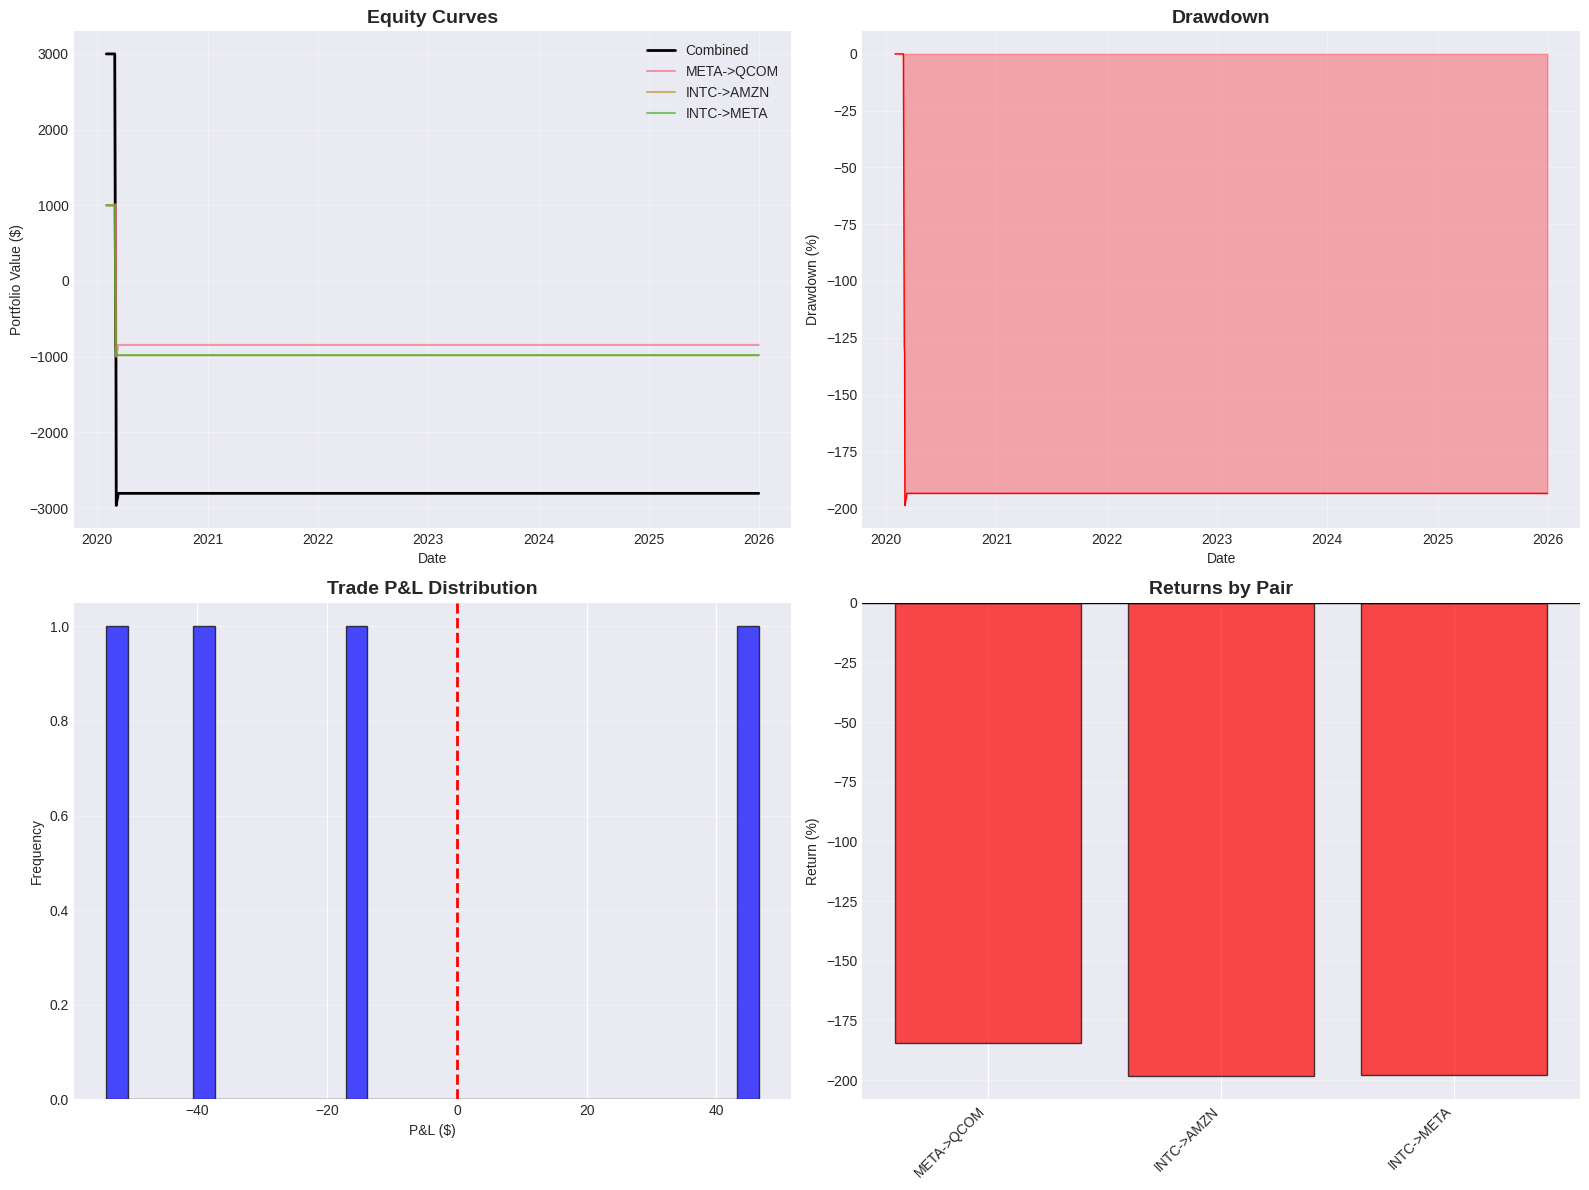

In [18]:
# Visualize results
if len(trading_pairs) > 0:
    backtester.plot_results()

In [19]:
# Create performance summary DataFrame
if len(trading_pairs) > 0:
    agg_metrics = results['aggregated']['metrics']
    
    summary_df = pd.DataFrame({
        'Metric': [
            'Total Return ($)',
            'Total Return (%)',
            'Number of Trades',
            'Win Rate (%)',
            'Profit Factor',
            'Max Drawdown (%)',
            'Sharpe Ratio',
            'Sortino Ratio',
            'Calmar Ratio'
        ],
        'Value': [
            f"${agg_metrics['total_return']:.2f}",
            f"{agg_metrics['total_return_pct']:.2f}%",
            agg_metrics['n_trades'],
            f"{agg_metrics['win_rate']:.2f}%",
            f"{agg_metrics['profit_factor']:.2f}",
            f"{agg_metrics['max_drawdown']:.2f}%",
            f"{agg_metrics['sharpe_ratio']:.2f}",
            f"{agg_metrics['sortino_ratio']:.2f}",
            f"{agg_metrics['calmar_ratio']:.2f}"
        ]
    })
    
    print("\nPerformance Summary:")
    print("="*80)
    display(summary_df)


Performance Summary:


,Metric,Value
0,Total Return ($),$-5805.94
1,Total Return (%),-193.53%
2,Number of Trades,4
3,Win Rate (%),25.00%
4,Profit Factor,0.43
5,Max Drawdown (%),198.84%
6,Sharpe Ratio,0.15
7,Sortino Ratio,0.02
8,Calmar Ratio,nan


In [20]:
# Per-pair performance comparison
if len(trading_pairs) > 0:
    pair_metrics_list = []
    for pair_name, result in results['pair_results'].items():
        metrics = result['metrics']
        pair_metrics_list.append({
            'Pair': pair_name,
            'Return ($)': f"${metrics['total_return']:.2f}",
            'Return (%)': f"{metrics['total_return_pct']:.2f}%",
            'Trades': metrics['n_trades'],
            'Win Rate': f"{metrics['win_rate']:.1f}%",
            'Max DD (%)': f"{metrics['max_drawdown']:.2f}%",
            'Sharpe': f"{metrics['sharpe_ratio']:.2f}"
        })
    
    pair_comparison_df = pd.DataFrame(pair_metrics_list)
    print("\nPer-Pair Performance:")
    print("="*80)
    display(pair_comparison_df)


Per-Pair Performance:


,Pair,Return ($),Return (%),Trades,Win Rate,Max DD (%),Sharpe
0,META->QCOM,$-1845.27,-184.53%,2,50.0%,198.66%,-0.45
1,INTC->AMZN,$-1981.93,-198.19%,1,0.0%,198.19%,-0.40
2,INTC->META,$-1978.75,-197.87%,1,0.0%,197.87%,-0.40


## Save Results

In [21]:
# Save results to CSV files
if len(trading_pairs) > 0:
    output_dir = Path(config['output']['results_dir'])
    output_dir.mkdir(exist_ok=True)
    
    # Save trading pairs
    trading_pairs.to_csv(output_dir / 'trading_pairs.csv', index=False)
    print(f"Trading pairs saved to {output_dir / 'trading_pairs.csv'}")
    
    # Save aggregated metrics
    summary_df.to_csv(output_dir / 'performance_summary.csv', index=False)
    print(f"Performance summary saved to {output_dir / 'performance_summary.csv'}")
    
    # Save per-pair metrics
    pair_comparison_df.to_csv(output_dir / 'pair_comparison.csv', index=False)
    print(f"Pair comparison saved to {output_dir / 'pair_comparison.csv'}")
    
    # Save equity curve
    equity_df = pd.DataFrame({
        'date': results['aggregated']['dates'],
        'equity': results['aggregated']['equity_curve']
    })
    equity_df.to_csv(output_dir / 'equity_curve.csv', index=False)
    print(f"Equity curve saved to {output_dir / 'equity_curve.csv'}")
    
    print(f"\nAll results saved to {output_dir}")

Trading pairs saved to results/trading_pairs.csv
Performance summary saved to results/performance_summary.csv
Pair comparison saved to results/pair_comparison.csv
Equity curve saved to results/equity_curve.csv

All results saved to results
